# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #10
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 14th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

During the course of the semester you have worked with a considerable number of sophisticated models. In previous homeworks, you have focused on developing algorithms for performing inference on or prediction using these models. In this assignment, much like in Long Homework #3, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

## Problem #1: A Study of Census Data

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). 

You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

# imports and get our hw dataset - 

In [1]:
import scipy.stats as stats
from scipy.integrate import quad as integrate
from scipy.stats import norm

import numpy as np
import scipy as sp
from scipy.integrate import quad as integrate
from scipy.stats import norm
import math
import random
from math import e, sqrt, pi
inf = float("inf")

import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('poster')

from pymc3 import Model,Normal,HalfNormal,Bernoulli,find_MAP,NUTS,sample,Slice,traceplot
import pymc3 as pm
import theano as T

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

df = pd.read_csv("census_data.csv",index_col=0)
df.head()

,age,sector,edu,marital,race,sex,earning
0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


# aggregate the data into 7 categories - 

In [2]:
seven_edu_cats = \
{'10th': "Some/no HS",
 '11th': "Some/no HS",
 '12th': "Some/no HS",
 '1st-4th': "Some/no HS",
 '5th-6th': "Some/no HS",
 '7th-8th': "Some/no HS",
 '9th': "Some/no HS",
 'Assoc-acdm': "Some-college",
 'Assoc-voc': "Prof./Voc. School",
 'Bachelors': 'Bachelors',
 'Doctorate': 'Doctorate',
 'HS-grad': 'HS-grad',
 'Masters': 'Masters',
 'Preschool': "Some/no HS",
 'Prof-school': "Prof./Voc. School",
 'Some-college': "Some-college"}

df['edu'] = df['edu'].map(seven_edu_cats)
df['edu'] = pd.Categorical(df['edu'],
            ['Some/no HS','HS-grad','Prof./Voc. School','Some-college','Bachelors','Masters','Doctorate'])

df.groupby('edu').size()

edu
Some/no HS            4253
HS-grad              10501
Prof./Voc. School     1958
Some-college          8358
Bachelors             5355
Masters               1723
Doctorate              413
dtype: int64

# get counts for gender and earnings including above and below 50k - 

In [3]:
total_counts_sum = pd.DataFrame({'n':df.groupby(['earning']).size()}).T
total_counts_sum['n'] = total_counts_sum['<=50K'] +  total_counts_sum['>50K'] 

counts = pd.DataFrame({'n':df.groupby(['edu','sex','earning']).size()})
counts = counts.unstack().reset_index()
counts.columns = counts.columns.get_level_values(0)
counts.columns = ['edu','sex','<=50K','>50K']
counts.sex = counts.sex.astype("category")
counts['n'] = counts.sum(axis=1)
counts['female'] = pd.get_dummies(counts.sex)['Female']
counts = counts[['edu','sex','female', '<=50K', '>50K', 'n']]
counts

,edu,sex,female,<=50K,>50K,n
0,Some/no HS,Female,1.0,1298,23,1321
1,Some/no HS,Male,0.0,2711,221,2932
2,HS-grad,Female,1.0,3164,226,3390
3,HS-grad,Male,0.0,5662,1449,7111
4,Prof./Voc. School,Female,1.0,483,109,592
5,Prof./Voc. School,Male,0.0,691,675,1366
6,Some-college,Female,1.0,2974,253,3227
7,Some-college,Male,0.0,3732,1399,5131
8,Bachelors,Female,1.0,1280,339,1619
9,Bachelors,Male,0.0,1854,1882,3736


# 1 (a) - Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above $50k and 0 being below), one of these models should include the effect of gender while the other should not.

#### Model 1: Earnings > 50k, not including gender:

We can fit a general linear model for the number of high earners, $n^{H}_i$, as it relates to the education level $i$ 

$$
\begin{align}
&n_i^{H} \sim \text{Bin}(n_i, p_i) \\
&\text{logit}(p_i) = \alpha_i \\
&\alpha_i \sim Normal(0, 10) \\
\end{align}
$$

#### Model 2: Earnings > 50k as a function of gender:

We can also fit a general linear model for whether or not the person will earn greater than 50k a year, as a function of gender.

$m^{(i)} = \mathbb{I}[\text{person i is male}]$

$$
\begin{align}
&n_i^{H} \sim \text{Bin}(n_i, p_i) \\
&\text{logit}(p_i) = \alpha_i + \beta m_i\\
&\alpha_i \sim Normal(0, 10) \\
&\beta \sim Normal(0, 10)
\end{align}
$$

In [4]:
# 5k interations for our sampling
number_of_iterations = 5000

# Baseline intercept only model
log_reg = pm.Model() 
with log_reg:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    # Inverse logit
    p = pm.Deterministic('p', 1/(1 + T.tensor.exp(-(alpha))))
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('Y_obs', p=p, observed=counts['>50K'], n=counts.n)
    
    trace_log_reg = pm.sample(number_of_iterations, progressbar=True)

# high earnings as a function of gender
log_reg_using_gender = pm.Model()     
with log_reg_using_gender:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10)
    eta = alpha + beta*counts.female
    # Inverse logit
    p = pm.Deterministic('p', 1/(1 + T.tensor.exp(-(eta))))
    Y_obs = pm.Binomial('Y_obs', p=p, observed=counts['>50K'], n=counts.n)

    trace_log_reg_using_gender = pm.sample(number_of_iterations, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  9%|▉         | 18359/200000 [00:01<00:09, 18412.86it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -3,723.5

100%|██████████| 5000/5000 [00:01<00:00, 3105.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,974:  10%|█         | 20889/200000 [00:01<00:10, 17300.54it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -2,430.8

100%|██████████| 5000/5000 [00:02<00:00, 2037.48it/s]


## traceplot of HIGH EARNINGS but NOT using GENDER -

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10633da58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cf1ee80>]], dtype=object)

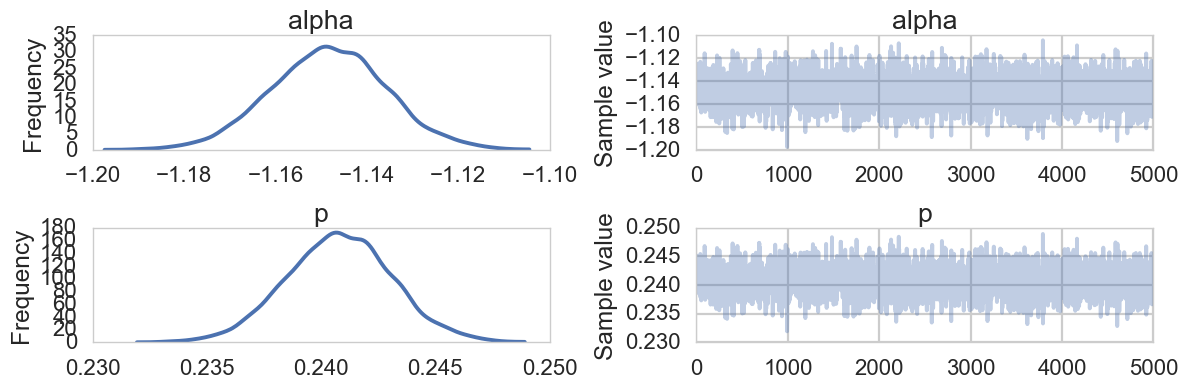

In [5]:
pm.traceplot(trace_log_reg)

The posterior estimamte for ℙ[high earner] does not appear to have a lot of uncertainty.  From the above plots, we can see both chains have converged.

## traceplot of HIGH EARNINGS as a function of GENDER -

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11dd80940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e3b9320>]], dtype=object)

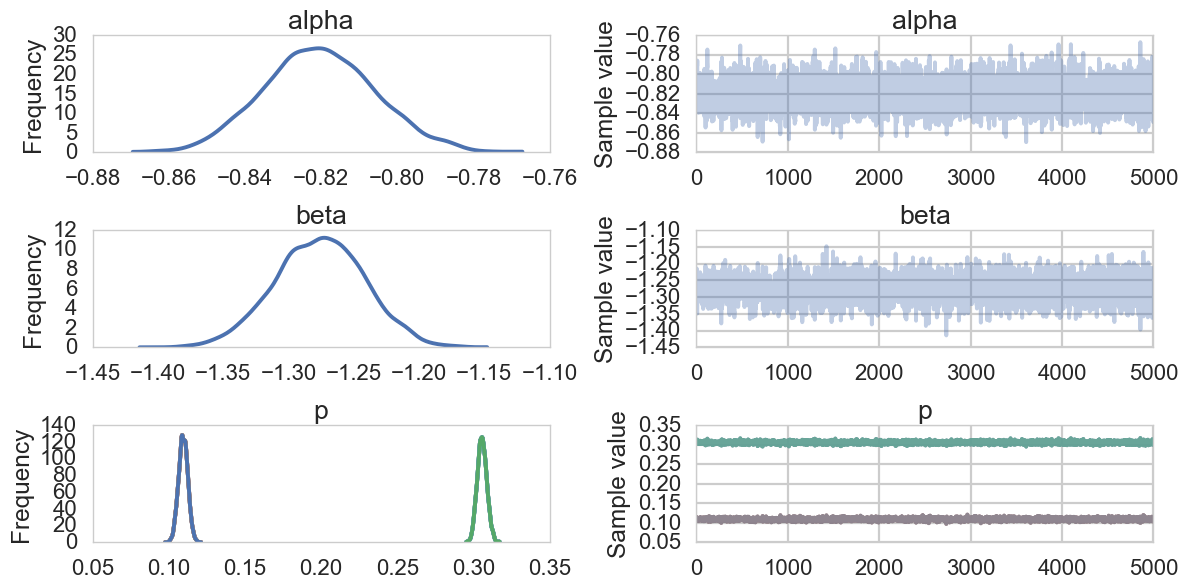

In [6]:
pm.traceplot(trace_log_reg_using_gender)

We can see the two bell-shaped curves that are centered near 0.12 (for females) and 0.31 (for males), which depict the probability of earning greater than $50k by gender.

# 1 (b) - Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

In [7]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models)
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

dfc = make_compare(['log_reg','log_reg_using_gender'],
             [trace_log_reg,trace_log_reg_using_gender],
             [log_reg,log_reg_using_gender])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
log_reg_using_gender,4639.01,479.927,0,1,1178.76,0,1
log_reg,6169.71,386.587,1530.7,0,1581.61,506033,1


Based on above results it seems that the model that considers the effect of gender better fits the data.

# examine the PREDICTED vs OBSERVED counts for both models - 

In [8]:
def predict_log_reg(row):
    alpha = trace_log_reg['alpha'].mean()
    eta = (alpha)
    return round((1/(1 + np.exp(-(eta))))*row.n)

def predict_log_reg_using_gender(row):
    alpha = trace_log_reg_using_gender['alpha'].mean()
    beta = trace_log_reg_using_gender['beta'].mean()
    eta = (alpha + beta*row.female)
    return round((1/(1 + np.exp(-(eta))))*row.n)

predictions_out = pd.DataFrame({
    'edu':counts.edu,
    'sex':counts.sex,
    'obs >50K':counts['>50K'],
    'log_reg':counts.apply(predict_log_reg,axis=1),
    'log_reg_w_g':counts.apply(predict_log_reg_using_gender,axis=1)})

predictions_out = predictions_out[['edu','sex','obs >50K','log_reg','log_reg_w_g']]
predictions_out 

,edu,sex,obs >50K,log_reg,log_reg_w_g
0,Some/no HS,Female,23,318.0,145.0
1,Some/no HS,Male,221,706.0,896.0
2,HS-grad,Female,226,816.0,371.0
3,HS-grad,Male,1449,1712.0,2174.0
4,Prof./Voc. School,Female,109,143.0,65.0
5,Prof./Voc. School,Male,675,329.0,418.0
6,Some-college,Female,253,777.0,353.0
7,Some-college,Male,1399,1235.0,1569.0
8,Bachelors,Female,339,390.0,177.0
9,Bachelors,Male,1882,900.0,1142.0


This further supports that including gender as a predictor improves the outcome. 

# set up the augmented dataframe for our POSTERIOR VALIDATION CHECK -

In [9]:
def get_error_values(trace, var):
    betas = pm.df_summary(trace).ix[var]
    mean = betas[0]
    hpd_2 = betas[3]
    hpd_97 = betas[4]
    return(mean,hpd_2,hpd_97)

def inverse_logit(x):
    return 1/(1 + np.exp(-(x)))

def p_values_log_reg(row):
    alpha, hpd_2, hpd_97 = get_error_values(trace_log_reg,'alpha')
    etas = inverse_logit(np.array([alpha, hpd_2, hpd_97]))
    return pd.Series({'pvalue':etas[0],'hpd_2.5': etas[1],'hpd_97.5': etas[2]})


def p_values_log_reg_using_gender(row):
    alpha, hpd_2, hpd_97 = get_error_values(trace_log_reg_using_gender,'alpha')
    beta, b_hpd_2, b_hpd_97 = get_error_values(trace_log_reg_using_gender,'beta')
    eta = (alpha + beta*row.female)
    etas = inverse_logit(np.array([(alpha + beta*row.female),
                               (alpha + b_hpd_2*row.female),
                               (alpha + b_hpd_97*row.female)]))
    return pd.Series({'p_val':etas[0],'hpd_2.5': etas[1],'hpd_97.5': etas[2]})

graph_error_bars = counts.apply(p_values_log_reg_using_gender,axis=1)
graph_error_bars.head()

,hpd_2.5,hpd_97.5,p_val
0,0.103168,0.116181,0.109457
1,0.305695,0.305695,0.305695
2,0.103168,0.116181,0.109457
3,0.305695,0.305695,0.305695
4,0.103168,0.116181,0.109457


In [10]:
p_values = pd.DataFrame({
    'edu':counts.edu,
    'sex':counts.sex,
    'obs':counts['>50K']/counts.n,
    'p_val':graph_error_bars.p_val,
    'hpd_2.5':graph_error_bars['hpd_2.5'],
    'hpd_97.5':graph_error_bars['hpd_97.5']})
    
p_values = p_values[['edu','sex','obs','p_val','hpd_2.5','hpd_97.5']]
p_values

,edu,sex,obs,p_val,hpd_2.5,hpd_97.5
0,Some/no HS,Female,0.017411,0.109457,0.103168,0.116181
1,Some/no HS,Male,0.075375,0.305695,0.305695,0.305695
2,HS-grad,Female,0.066667,0.109457,0.103168,0.116181
3,HS-grad,Male,0.203769,0.305695,0.305695,0.305695
4,Prof./Voc. School,Female,0.184122,0.109457,0.103168,0.116181
5,Prof./Voc. School,Male,0.494143,0.305695,0.305695,0.305695
6,Some-college,Female,0.078401,0.109457,0.103168,0.116181
7,Some-college,Male,0.272656,0.305695,0.305695,0.305695
8,Bachelors,Female,0.209389,0.109457,0.103168,0.116181
9,Bachelors,Male,0.503747,0.305695,0.305695,0.305695


# plot the Posterior Validation Check -

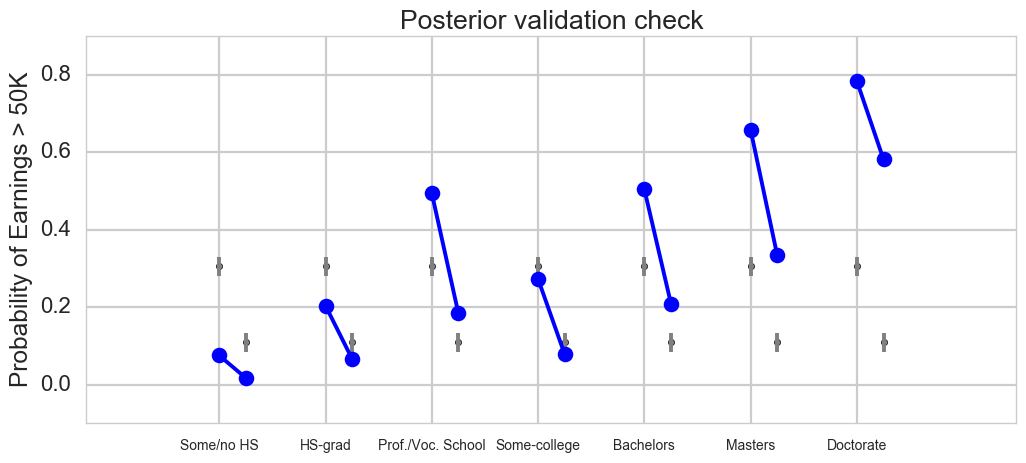

In [11]:
labels = p_values[p_values.index.values % 2 ==0].edu

plt.figure(figsize=(12,5))
for name,group in p_values.groupby(['edu']):
    i = group.index.values[0]*2
    y2,y1 = group['obs'].values
    plt.plot([i,i+1], [y1,y2],marker='o',c='blue')
    
    y_2,y_1 = group['p_val'].values
    plt.scatter([i,i+1],[y_1,y_2],c='gray')
        
    plt.errorbar([i,i+1],[y_1,y_2],yerr=0.00605*4, linestyle="None", c='gray')
    
plt.ylabel('Probability of Earnings > 50K')
plt.xticks(labels.index.values*2, labels.values, fontsize=10)
plt.title('Posterior validation check')
plt.show()

This plot shows the over-served values in each educational category (represented by the blue line) as it decreases from male to female.  Error bars are shown in gray, and represent the predicted proportions for male and female by the second model.  The error bars do not move as we did not consider educational level in the previous model.  Overall the graph shows a clear trend with gender, as males have a higher probability of being high earners across all educational levels. 

However this does not tell the whole story as each of the blue lines are of different lengths, suggesting that this model is missing important information on how much income varies in accordance with gender at each educational level, a vary intercept.

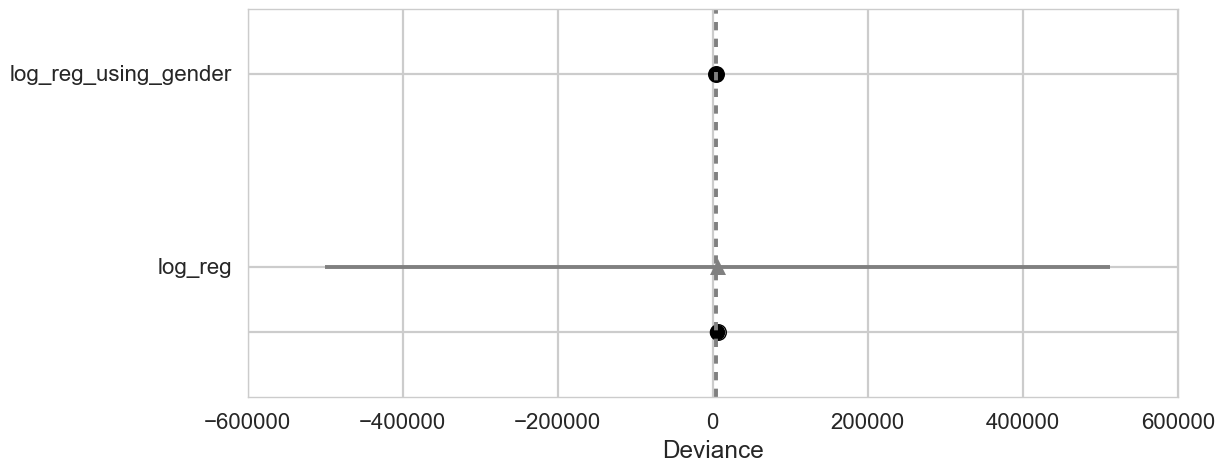

In [12]:
def compare_plot(comp_df, ax=None):
    """
    Model comparison summary plot in the style of the one used in the book
    Statistical Rethinking by Richard McElreath.
    Parameters
    ----------
    comp_df: DataFrame
        The result of the pm.compare() function
    ax : axes
        Matplotlib axes. Defaults to None.
    Returns
    -------
    ax : matplotlib axes
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(12,5))

    yticks_pos, step = np.linspace(0, -1, (comp_df.shape[0] * 2) - 1, retstep=True)
    yticks_pos[1::2] = yticks_pos[1::2] + step / 2

    yticks_labels = [''] * len(yticks_pos)
    yticks_labels[0] = comp_df.index[0]
    yticks_labels[1::2] = comp_df.index[1:]

    data = comp_df.values
    min_ic = data[0, 0]

    ax.errorbar(x=data[:, 0], y=yticks_pos[::2], xerr=data[:, 4],
                fmt='ko', mfc='None', mew=1)
    ax.errorbar(x=data[1:, 0], y=yticks_pos[1::2],
                xerr=data[1:, 5], fmt='^', color='grey')

    ax.plot(data[:, 0] - (2 * data[:, 1]), yticks_pos[::2], 'ko')
    ax.axvline(min_ic, ls='--', color='grey')

    ax.set_yticks(yticks_pos)
    ax.set_yticklabels(yticks_labels)
    ax.set_xlabel('Deviance')
    lims=ax.get_ylim()
    ax.set_ylim(lims[0] + step/2., lims[1] - step/2.)
    return ax

compare_plot(dfc)

From this we can see that being female decreases the likelihood of being a high earner.  This can be observed in the mean of the beta value from our predictive model that includes gender.

# 1 (c) - Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education.

In [13]:
counts = pd.merge(counts,pd.get_dummies(counts.edu),left_index=True,right_index=True)

# taking into account education without gender
log_reg_education = pm.Model() 
Xs = [counts.iloc[:,i] for i in range(6,13)]
with log_reg_education:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=7)
    # Inverse logit
    eta =  alpha + T.dot(beta,Xs)
    p = pm.Deterministic('p', 1/(1 + T.tensor.exp(-(eta))))
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('Y_obs', p=p, observed=counts['>50K'], n=counts.n)
    
    trace_log_reg_education = pm.sample(number_of_iterations, progressbar=True)
    
# taking into account education with gender 
Xs = [counts['female']] + [counts.iloc[:,i] for i in range(6,13)]
log_reg_using_gender_education = pm.Model()     
with log_reg_using_gender_education:
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=8)
    eta =  alpha + T.dot(beta,Xs)
        
    # Inverse logit
    p = pm.Deterministic('p', 1/(1 + T.tensor.exp(-(eta))))
    Y_obs = pm.Binomial('Y_obs', p=p, observed=counts['>50K'], n=counts.n)

    trace_log_reg_using_gender_education = pm.sample(number_of_iterations, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,336.8:  13%|█▎        | 25594/200000 [00:01<00:12, 14304.30it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,037.5

100%|██████████| 5000/5000 [00:49<00:00, 104.65it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -103.78: 100%|██████████| 200000/200000 [00:12<00:00, 15428.40it/s]
Finished [100%]: Average ELBO = -103.78
100%|██████████| 5000/5000 [00:51<00:00, 97.46it/s] 


# 1 (d) - Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

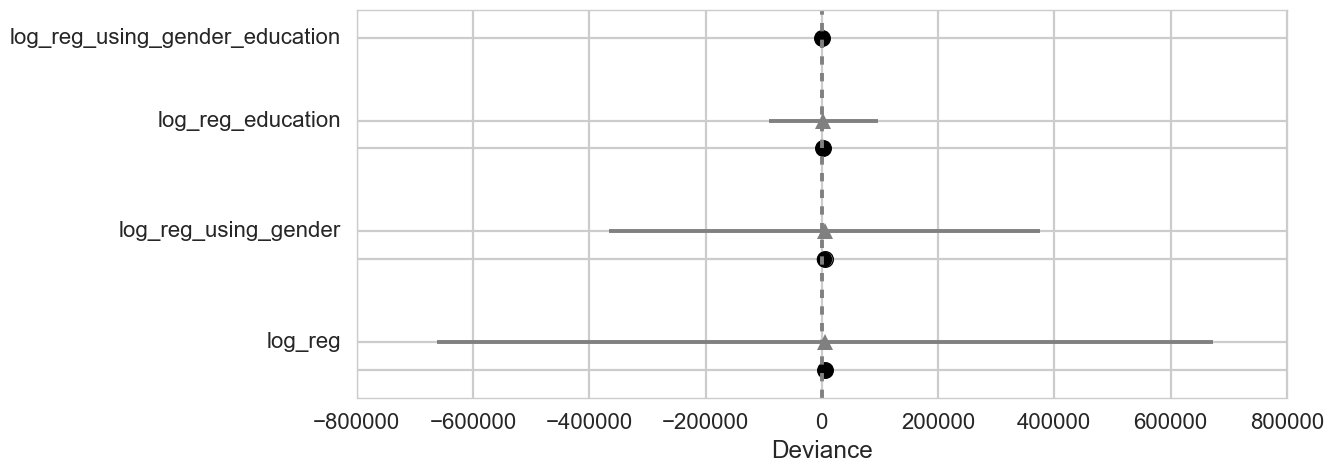

In [14]:
dfc = make_compare(['log_reg','log_reg_using_gender','log_reg_education','log_reg_using_gender_education'],
             [trace_log_reg,trace_log_reg_using_gender,trace_log_reg_education,trace_log_reg_using_gender_education],
             [log_reg,log_reg_using_gender,log_reg_education,log_reg_using_gender_education])
dfc

compare_plot(dfc)

## traceplot using EDUCATION but not GENDER -

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11baa1940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cc1cc18>]], dtype=object)

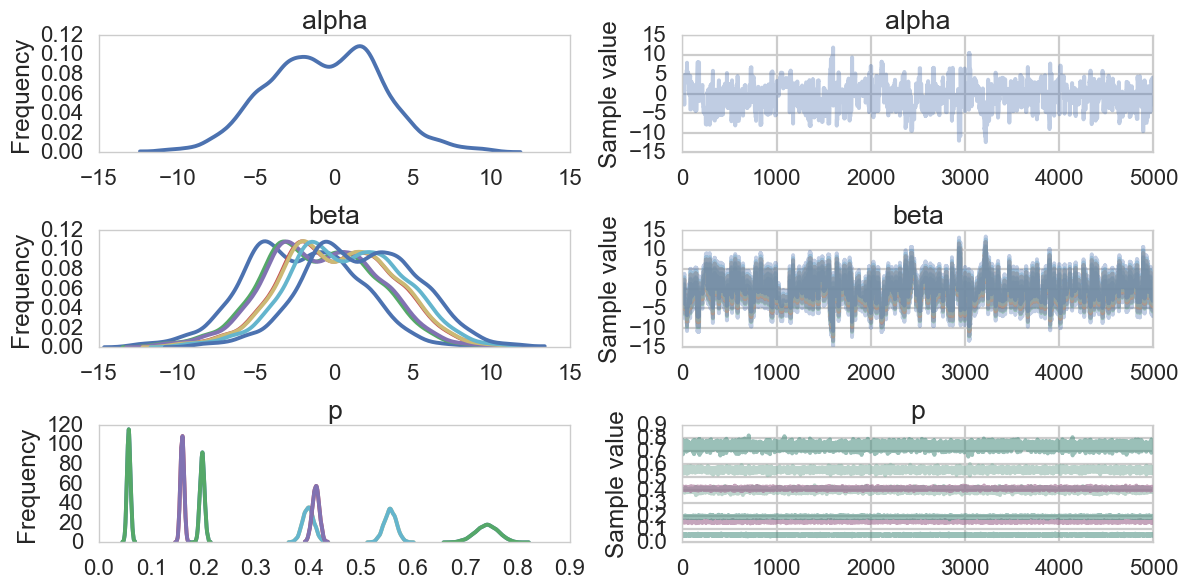

In [15]:
pm.traceplot(trace_log_reg_education)

## traceplot using EDUCATION and GENDER

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d9a5ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121a497f0>]], dtype=object)

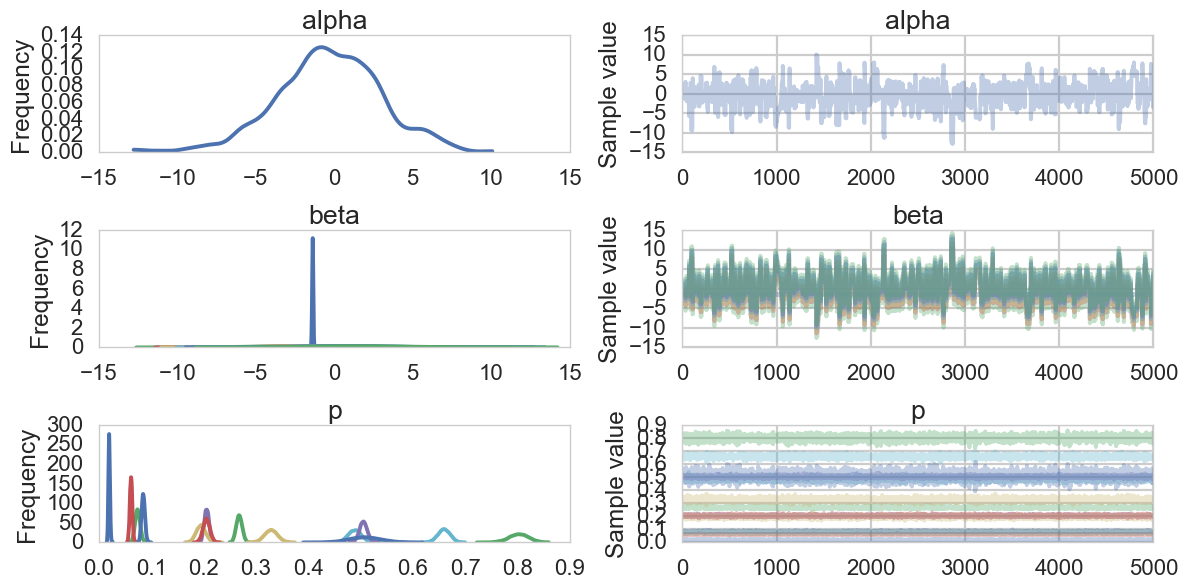

In [16]:
pm.traceplot(trace_log_reg_using_gender_education)

# calculate and examine the POSTERIOR PREDICTIVE -

In [17]:
def log_reg_using_education(row):
    alpha = trace_log_reg_using_gender['alpha'].mean()
    betas = [b.mean() for b in trace_log_reg_education['beta'].T]
    Xs = [row[i] for i in range(6,13)]
    eta = alpha + np.dot(betas,Xs)
    return round((1/(1 + np.exp(-(eta))))*row.n)

def log_reg_using_gender_education(row):
    alpha = trace_log_reg_using_gender['alpha'].mean()
    betas = [b.mean() for b in trace_log_reg_using_gender_education['beta'].T]
    Xs = [row['female']] + [row[i] for i in range(6,13)]
    eta = alpha + np.dot(betas,Xs)
    return round((1/(1 + np.exp(-(eta))))*row.n)

predictions_out['log_reg_using_education'] = counts.apply(log_reg_using_education, axis=1)
predictions_out['log_reg_using_gender_education'] = counts.apply(log_reg_using_gender_education, axis=1)
predictions_out

,edu,sex,obs >50K,log_reg,log_reg_w_g,log_reg_using_education,log_reg_using_gender_education
0,Some/no HS,Female,23,318.0,145.0,64.0,17.0
1,Some/no HS,Male,221,706.0,896.0,141.0,140.0
2,HS-grad,Female,226,816.0,371.0,462.0,134.0
3,HS-grad,Male,1449,1712.0,2174.0,969.0,992.0
4,Prof./Voc. School,Female,109,143.0,65.0,211.0,78.0
5,Prof./Voc. School,Male,675,329.0,418.0,488.0,511.0
6,Some-college,Female,253,777.0,353.0,548.0,177.0
7,Some-college,Male,1399,1235.0,1569.0,872.0,956.0
8,Bachelors,Female,339,390.0,177.0,600.0,225.0
9,Bachelors,Male,1882,900.0,1142.0,1385.0,1456.0


In [18]:
def p_val_log_reg_using_education(row):
    alpha = trace_log_reg_using_gender['alpha'].mean()
    betas = [b.mean() for b in trace_log_reg_education['beta'].T]
    Xs = [row[i] for i in range(6,13)]
    eta = alpha + np.dot(betas,Xs)
    return (1/(1 + np.exp(-(eta))))

def p_val_log_reg_using_gender_education(row):
    alpha = trace_log_reg_using_gender['alpha'].mean()
    betas = [b.mean() for b in trace_log_reg_using_gender_education['beta'].T]
    Xs = [row['female']] + [row[i] for i in range(6,13)]
    eta = alpha + np.dot(betas,Xs)
    return (1/(1 + np.exp(-(eta))))

p_values['log_reg_using_education'] = counts.apply(p_val_log_reg_using_education,axis=1)
p_values['p_val_log_reg_using_gender_education'] = counts.apply(p_val_log_reg_using_gender_education,axis=1)
p_values

,edu,sex,obs,p_val,hpd_2.5,hpd_97.5,log_reg_using_education,p_val_log_reg_using_gender_education
0,Some/no HS,Female,0.017411,0.109457,0.103168,0.116181,0.048086,0.012511
1,Some/no HS,Male,0.075375,0.305695,0.305695,0.305695,0.048086,0.047657
2,HS-grad,Female,0.066667,0.109457,0.103168,0.116181,0.136198,0.039415
3,HS-grad,Male,0.203769,0.305695,0.305695,0.305695,0.136198,0.139468
4,Prof./Voc. School,Female,0.184122,0.109457,0.103168,0.116181,0.357012,0.131452
5,Prof./Voc. School,Male,0.494143,0.305695,0.305695,0.305695,0.357012,0.374138
6,Some-college,Female,0.078401,0.109457,0.103168,0.116181,0.169927,0.054787
7,Some-college,Male,0.272656,0.305695,0.305695,0.305695,0.169927,0.186293
8,Bachelors,Female,0.209389,0.109457,0.103168,0.116181,0.370586,0.139109
9,Bachelors,Male,0.503747,0.305695,0.305695,0.305695,0.370586,0.389590


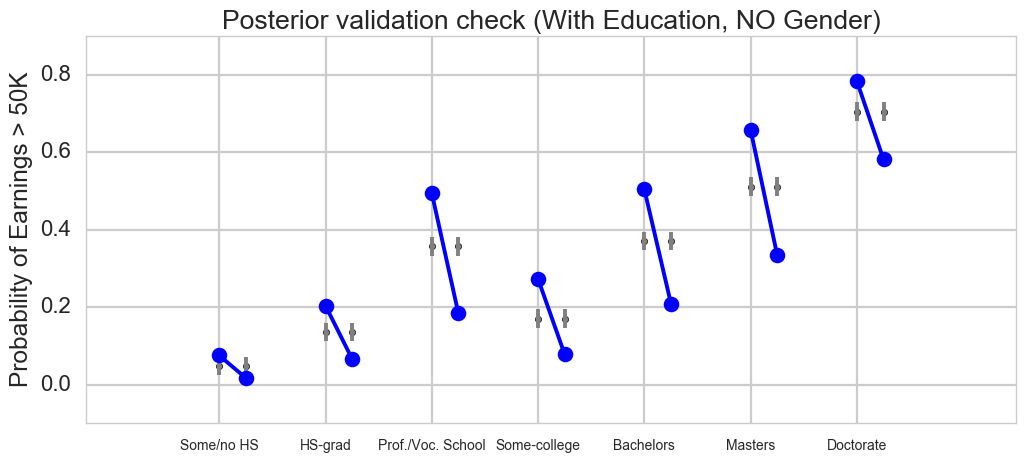

In [19]:
labels = p_values[p_values.index.values % 2 ==0].edu

plt.figure(figsize=(12,5))
for name,group in p_values.groupby(['edu']):
    i = group.index.values[0]*2
    y2,y1 = group['obs'].values
    plt.plot([i,i+1], [y1,y2],marker='o',c='blue')
    
    y_2,y_1 = group['log_reg_using_education'].values
    plt.scatter([i,i+1],[y_1,y_2],c='gray')
        
    plt.errorbar([i,i+1],[y_1,y_2],yerr=0.00605*4, linestyle="None", c='gray')
    
plt.ylabel('Probability of Earnings > 50K')
plt.xticks(labels.index.values*2, labels.values, fontsize=10)
plt.title('Posterior validation check (With Education, NO Gender)')
plt.show()

This demonstrates the probability of being a high earner when considering educational level, and not gender.  This shows that education level is a useful predictor that improves our understanding.

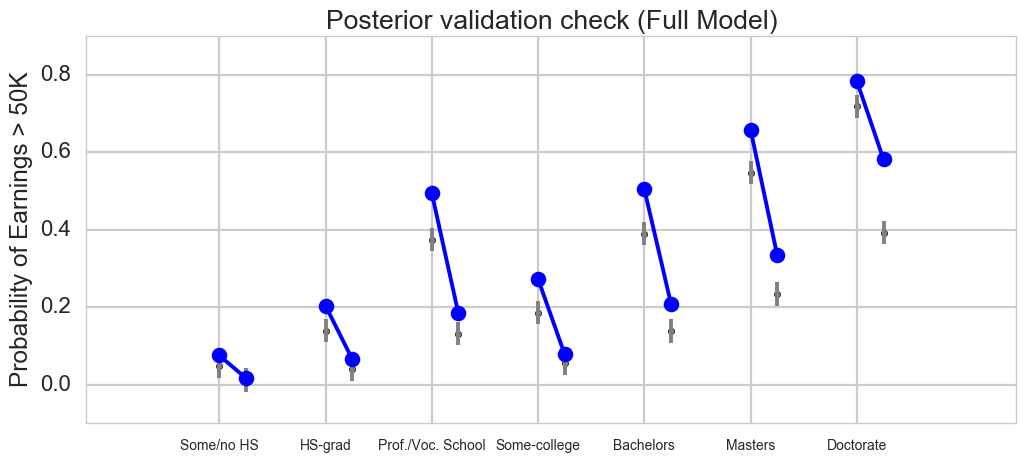

In [20]:
labels = p_values[p_values.index.values % 2 ==0].edu

plt.figure(figsize=(12,5))
for name,group in p_values.groupby(['edu']):
    i = group.index.values[0]*2
    y2,y1 = group['obs'].values
    plt.plot([i,i+1], [y1,y2],marker='o',c='blue')
    
    y_2,y_1 = group['p_val_log_reg_using_gender_education'].values
    plt.scatter([i,i+1],[y_1,y_2],c='gray')
        
    plt.errorbar([i,i+1],[y_1,y_2],yerr=0.00605*5, linestyle="None", c='gray')
    
plt.ylabel('Probability of Earnings > 50K')
plt.xticks(labels.index.values*2, labels.values, fontsize=10)
plt.title('Posterior validation check (Full Model)')
plt.show()

This last model looks at both educational level and gender as predictors for being high earners.  This performs better than the previous models as it captures the offsets for each educational level, and benefits conferred for being male.   

Our model shows that while educational level is a useful predictor for being a high earner, being female nevertheless negatively correlates with the probability of being a high earner. 